# Text-to-Speech LightSpeech

LightSpeech, Text to Melspectrogram.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/tts-lightspeech](https://github.com/huseinzol05/malaya-speech/tree/master/example/tts-lightspeech).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import matplotlib.pyplot as plt
import IPython.display as ipd

### LightSpeech description

1. Malaya-speech FastSpeech2 will generate melspectrogram with feature size 80.
2. Use Malaya-speech vocoder to convert melspectrogram to waveform.
3. Cannot generate more than melspectrogram longer than 2000 timestamp, it will throw an error. Make sure the texts are not too long.

### List available LightSpeech

In [2]:
malaya_speech.tts.available_lightspeech()

,Size (MB),Quantized Size (MB),Understand punctuation,Is lowercase
osman,167,43.3,True,False
yasmin,167,43.3,True,False


### Load LightSpeech model

Fastspeech2 use text normalizer from Malaya, https://malaya.readthedocs.io/en/latest/load-normalizer.html#Load-normalizer,

Make sure you install Malaya version > 4.0 to make it works, **to get better speech synthesis, make sure Malaya version > 4.9.1**,

```bash
pip install malaya -U
```

```python
def lightspeech(
    model: str = 'male',
    quantized: bool = False,
    pad_to: int = 8,
    **kwargs
):
    """
    Load LightSpeech TTS model.

    Parameters
    ----------
    model : str, optional (default='male')
        Model architecture supported. Allowed values:

        * ``'yasmin'`` - LightSpeech trained on female Yasmin voice.
        * ``'osman'`` - LightSpeech trained on male Osman voice.

    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model.
        Quantized model not necessary faster, totally depends on the machine.
    pad_to : int, optional (default=8)
        size of pad character with 0. Increase can stable up prediction on short sentence, we trained on 8.

    Returns
    -------
    result : malaya_speech.model.synthesis.Fastspeech class
    """
```

In [5]:
male = malaya_speech.tts.lightspeech(model = 'osman')

In [4]:
# https://www.sinarharian.com.my/article/115216/BERITA/Politik/Syed-Saddiq-pertahan-Dr-Mahathir
string1 = 'Syed Saddiq berkata, mereka seharusnya mengingati bahawa semasa menjadi Perdana Menteri Pakatan Harapan'

### Predict

```python
def predict(
    self,
    string,
    speed_ratio: float = 1.0,
    f0_ratio: float = 1.0,
    energy_ratio: float = 1.0,
):
    """
    Change string to Mel.

    Parameters
    ----------
    string: str
    speed_ratio: float, optional (default=1.0)
        Increase this variable will increase time voice generated.
    f0_ratio: float, optional (default=1.0)
        Increase this variable will increase frequency, low frequency will generate more deeper voice.
    energy_ratio: float, optional (default=1.0)
        Increase this variable will increase loudness.

    Returns
    -------
    result: Dict[string, decoder-output, universal-output, mel-output]
    """
```

It only able to predict 1 text for single feed-forward.

In [5]:
r_male = male.predict(string1)

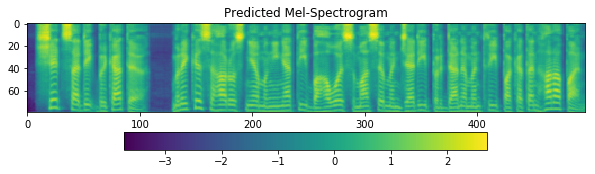

In [6]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-Spectrogram')
im = ax1.imshow(np.rot90(r_male['mel-output']), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

### Load Vocoder model

There are 2 ways to synthesize melspectrogram output from TTS models,

1. If you are going to use individual speaker vocoder, make sure the speakers are the same If use female tacotron2, need to use female MelGAN also. Use `mel-output` from TTS model. Read more at https://malaya-speech.readthedocs.io/en/latest/load-vocoder.html
2. If you are going to use universal MelGAN, use `universal-output` from TTS model. Read more at https://malaya-speech.readthedocs.io/en/latest/load-universal-melgan.html

We prefer individual speaker vocoder, size only 17MB and faster than universal vocoder.

In [7]:
universal_melgan = malaya_speech.vocoder.melgan(model = 'universal-1024')

In [8]:
y_ = universal_melgan(r_male['universal-output'])
ipd.Audio(y_, rate = 22050)

### Playing around with speed, f0 and energy ratio

In [9]:
r_male = male.predict(string1, speed_ratio = 1.5)

In [10]:
y_ = universal_melgan(r_male['universal-output'])
ipd.Audio(y_, rate = 22050)

In [11]:
r_male = male.predict(string1, f0_ratio = -1.5)

In [12]:
y_ = universal_melgan(r_male['universal-output'])
ipd.Audio(y_, rate = 22050)

### Combined everything using Pipeline

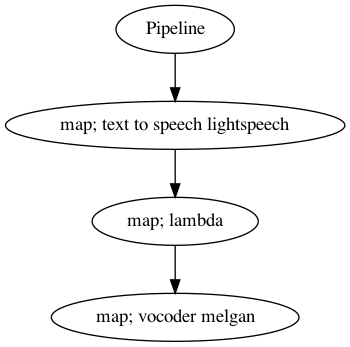

In [13]:
p = Pipeline()
pipeline = (
    p.map(male)
    .map(lambda x: x['universal-output'])
    .map(universal_melgan)
)
p.visualize()

In [14]:
r = p('husein wangi tetapi ketiak masam nasib baik kacak')

In [15]:
ipd.Audio(r['vocoder-melgan'], rate = 22050)

### Compare speed with Tacotron2

In [16]:
# https://www.hmetro.com.my/mutakhir/2020/12/657604/6-cadangan-tangani-kelemahan-kawal-selia-halal

text = 'Kuasa pensijilan halal, dan penguatkuasaan halal terletak di bawah bidang kuasa agensi yang berbeza.'

In [17]:
male_tacotron2 = malaya_speech.tts.tacotron2(model = 'osman')

In [22]:
%%time

r_male_tacotron2 = male_tacotron2.predict(text)

CPU times: user 2.9 s, sys: 59.7 ms, total: 2.96 s
Wall time: 2.66 s


In [19]:
y_ = universal_melgan(r_male_tacotron2['universal-output'])
ipd.Audio(y_, rate = 22050)

In [20]:
%%time

r_male = male.predict(text)

CPU times: user 235 ms, sys: 48.5 ms, total: 284 ms
Wall time: 61.6 ms


In [21]:
y_ = universal_melgan(r_male['universal-output'])
ipd.Audio(y_, rate = 22050)